In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [5]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-05 15:45:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-03-05 15:45:06 (85.2 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



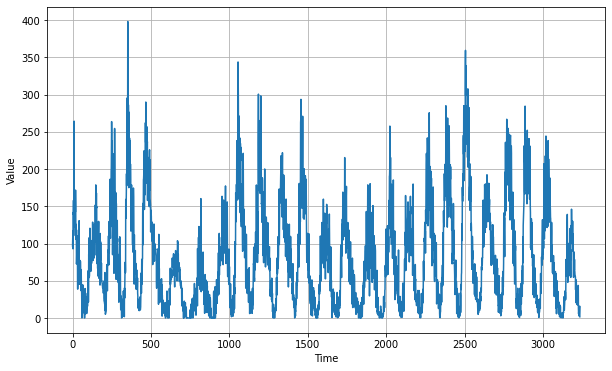

In [8]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

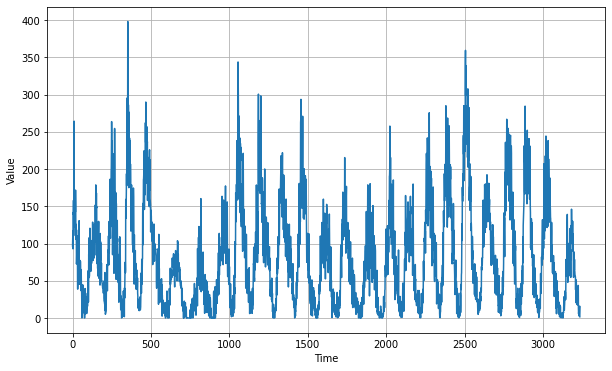

In [9]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 50
batch_size = 250
shuffle_buffer_size = 1000


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LayerNormalization(epsilon=1e-6),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/150
12/12 [==============================] - 6s 58ms/step - loss: 79.2856 - mae: 79.7686
Epoch 2/150
12/12 [==============================] - 1s 62ms/step - loss: 79.6988 - mae: 80.1829
Epoch 3/150
12/12 [==============================] - 1s 65ms/step - loss: 80.2535 - mae: 80.7367
Epoch 4/150
12/12 [==============================] - 1s 65ms/step - loss: 79.2167 - mae: 79.7008
Epoch 5/150
12/12 [==============================] - 1s 68ms/step - loss: 78.9896 - mae: 79.4729
Epoch 6/150
12/12 [==============================] - 1s 66ms/step - loss: 79.2417 - mae: 79.7253
Epoch 7/150
12/12 [==============================] - 1s 66ms/step - loss: 79.7146 - mae: 80.1986
Epoch 8/150
12/12 [==============================] - 1s 63ms/step - loss: 79.4628 - mae: 79.9465
Epoch 9/150
12/12 [==============================] - 1s 66ms/step - loss: 79.3607 - mae: 79.8442
Epoch 10/150
12/12 [=====

In [14]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

print(minmax(history.history["lr"]))
print(minmax(history.history["loss"]))

(1e-08, 0.2818383)
(32.743370056152344, 85.2535629272461)


(1e-08, 0.3018383, 30.0, 85.0)

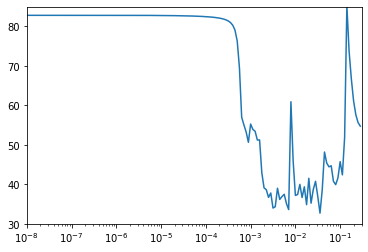

In [15]:
#updated_loss=history.history["loss"]*400
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 0.3018383 , 30, 85])


In [16]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LayerNormalization(epsilon=1e-6),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  
  #tf.keras.layers.LSTM(256, return_sequences=True),                    
  #tf.keras.layers.LSTM(128, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 15s 106ms/step - loss: 77.6357 - mae: 78.1223
Epoch 2/500
30/30 [==============================] - 3s 93ms/step - loss: 66.6263 - mae: 67.1236
Epoch 3/500
30/30 [==============================] - 3s 90ms/step - loss: 51.3207 - mae: 51.8188
Epoch 4/500
30/30 [==============================] - 3s 89ms/step - loss: 50.9021 - mae: 51.4001
Epoch 5/500
30/30 [==============================] - 3s 88ms/step - loss: 51.1220 - mae: 51.6201
Epoch 6/500
30/30 [==============================] - 3s 87ms/step - loss: 51.4992 - mae: 51.9973
Epoch 7/500
30/30 [==============================] - 3s 86ms/step - loss: 51.0030 - mae: 51.5010
Epoch 8/500
30/30 [==============================] - 3s 86ms/step - loss: 52.0661 - mae: 52.5642
Epoch 9/500
30/30 [==============================] - 3s 84ms/step - loss: 50.9315 - mae: 51.4295
Epoch 10/500
30/30 [==============================] - 3s 84ms/step - loss: 52.2120 - mae: 52.7099
Epoch 11/500
30/30 [=======

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

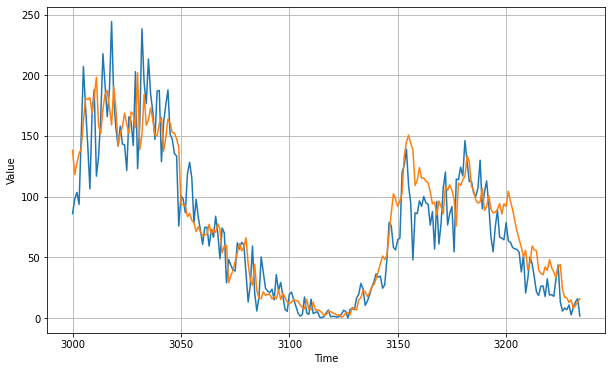

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.111359

<Figure size 432x288 with 0 Axes>

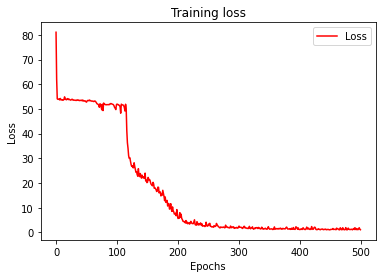

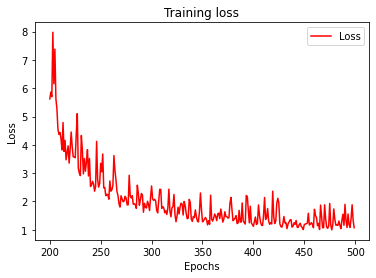

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)